# Predicting Amazon Review score using text

Here, over and above simply using a TF-IDF matrix to predict scores, I add topic model probabilities for each text, adding a topic-specific flavor to the model.

### Loading data

In [74]:
import json
import gensim
import nltk
import numpy as np
import pandas as pd
import re

df = pd.read_csv('Reviews.csv')

### Understanding the data

Removing HTML tags below using the fact tat they typically are of the form <..>. The way the below regex works is that any text b/w a **<** and *the first* **>** it encounters is removed. Example showed in cell below. Also, I remove the duplicates based on Product, User and Review text.

In [75]:
print ('Output of trial regex on <p>Hello</p>: ' + re.sub('<[^<]+?>', '', '<p>Hello</p>'))
df['Text'] = df['Text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

repeated = df.groupby(['ProductId', 'UserId', 'Text'])['Id'].count()
print ('%s duplicate observations' % len(repeated[repeated > 1]))
df = df.drop_duplicates(subset = ['ProductId', 'UserId', 'Text'], inplace = False, keep = 'first')
df = df.reset_index()

Output of trial regex on <p>Hello</p>: Hello
818 duplicate observations


In [76]:
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567140 entries, 0 to 567139
Data columns (total 11 columns):
index                     567140 non-null int64
Id                        567140 non-null int64
ProductId                 567140 non-null object
UserId                    567140 non-null object
ProfileName               567124 non-null object
HelpfulnessNumerator      567140 non-null int64
HelpfulnessDenominator    567140 non-null int64
Score                     567140 non-null int64
Time                      567140 non-null int64
Summary                   567113 non-null object
Text                      567140 non-null object
dtypes: int64(6), object(5)
memory usage: 47.6+ MB


### Word cloud

In [77]:
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

stopwords = set(STOPWORDS)

mpl.rcParams['font.size']=12                 
mpl.rcParams['savefig.dpi']=100              
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

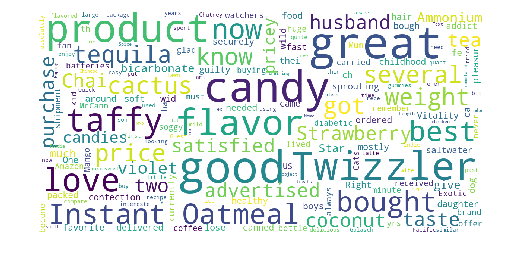

In [78]:
show_wordcloud(df[df['Score']>3].Text)

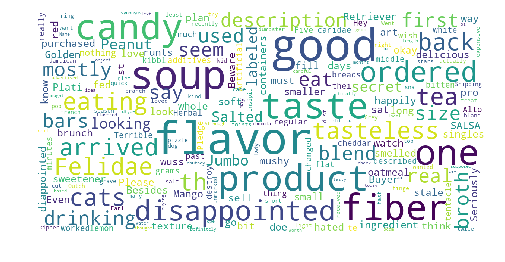

In [79]:
show_wordcloud(df[df['Score']<3].Text)

### Review rating in the dataset

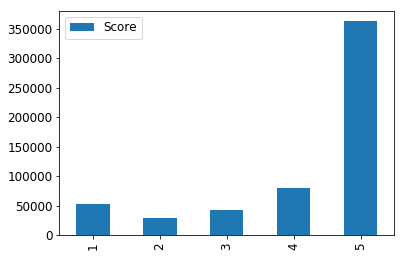

In [80]:
hist = pd.cut(df['Score'], 5, labels=[1,2,3,4,5]).value_counts(sort=False)
hist.to_frame().plot.bar()

### Word frequency across all reviews

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(analyzer='word', stop_words='english',min_df=2)
sparse_matrix = word_vectorizer.fit_transform(df['Text'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print (words.describe())
words.head(10)

           frequency
count   71139.000000
mean      285.299358
std      3007.766713
min         2.000000
25%         3.000000
50%         7.000000
75%        30.000000
max    255065.000000


,frequency
00,5041
000,773
0000,8
000001,2
00001,2
0001,2
0004brita,11
000i,2
000kwh,14
000mg,11


In [82]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

### Topic extraction with LDA

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 1000
n_components = 10
n_top_words = 25

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = vectorizer.fit_transform(df.Text)
feature_names = vectorizer.get_feature_names()

#print feature_names
lda = LatentDirichletAllocation(learning_method='online')
lda.fit(tfidf)
print("\nTopics in LDA model:")
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model:
Topic #0: bars cereal bar snack nuts granola fruit candy chewy healthy sweet subscribe yummy delicious pumpkin great crunchy tasty nut save crackers carbs pie love mixes
Topic #1: amazon price product great store shipping stores arrived order grocery local fast gift buy happy delivery loved item good purchase love excellent cheaper service thanks
Topic #2: jerky toy china awesome pill mango bed sleep hooked allergies night candies room form son helped pet lost site easier pounds child chew fridge nearly
Topic #3: like good just product taste great don really flavor little use love time ve buy bag make sugar eat better try tried box way water
Topic #4: dog food treats dogs cat loves cats treat eat love old chicken formula dry vet chew training teeth healthy baby puppy feed foods smell like
Topic #5: chips salt sauce flavor great like good soup spicy taste love just hot best rice chicken use cheese add potato low spice salty really make
Topic #6: coffee tea cup drin

Unlike the Twitter data, we see that the topics here are fairly well-defined! We can even pin-point topics about snacks, beverages and so on.

### Checking the distribution of topics over reviews

In [85]:
topic_distrib = lda.transform(tfidf[0])
print (df.iloc[0].Text, df.iloc[0].Score)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. 5


In [86]:
print (topic_distrib)
print ("topics ordered:", np.argsort(topic_distrib[0])[::-1][:])

[[0.02176838 0.02177541 0.02176636 0.19859784 0.49709225 0.02177198
  0.02177115 0.15191343 0.02177471 0.02176849]]
topics ordered: [4 3 7 1 8 5 6 9 0 2]


In [87]:
topic_distrib = lda.transform(tfidf[11])
print (df.iloc[11].Text, df.iloc[11].Score)

One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week. 5


In [88]:
print (topic_distrib)
print ("topics ordered:", np.argsort(topic_distrib[0])[::-1][:])

[[0.0237806  0.02378184 0.02378017 0.78593195 0.02380884 0.02378338
  0.02378489 0.02377915 0.02378304 0.02378615]]
topics ordered: [3 4 9 6 5 8 1 0 2 7]


## Creating labels, prediction models

In [104]:
df_model = df.copy()
df_model['Score'] = 1 * (df_model['Score'] > 3) - 1 * (df_model['Score'] < 3)
neutral_reviews = [i for i in range(len(df_model['Score'])) if df_model['Score'][i] == 0]
print (df_model.shape)
topic_distributions = lda.transform(tfidf)
topic_distributions = pd.DataFrame(topic_distributions, columns = ['X' + str(x) for x in range(topic_distributions.shape[1])])

(567140, 11)


In [117]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer

df_model_with_lda = df_model.join(topic_distributions, how = 'left')
df_model_with_lda = df_model_with_lda.drop(columns = ['Text', 'Summary', 'ProductId', 'UserId',
                                                      'Id', 'index', 'ProfileName'], inplace = False)
df_model_with_lda = df_model_with_lda.drop(df_model_with_lda.index[neutral_reviews])
print (df_model_with_lda.shape)

X = df_model_with_lda.drop(columns = ['Score'], inplace = False)
y = df_model_with_lda['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

(524582, 14)


In [129]:
scoring = {'accuracy': make_scorer(accuracy_score), 'prec': 'precision'}

"""
for n_estimators in [100, 500]:
    for max_depth in [3, 10]:
        clf = GradientBoostingClassifier(n_estimators = n_estimators,
                                         max_depth = max_depth,
                                         learning_rate = 0.1)
        cv_results = cross_validate(clf, X_train, y_train, scoring=scoring)
        print ("Avg Accuracy and precision on CV set for %d estimators with max tree depth of %d are, respectively: %f and %f"
               % (n_estimators, max_depth, np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_prec'])))
"""

clf = GradientBoostingClassifier(n_estimators = 300, max_depth = 5, learning_rate = 0.1)
cv_results = cross_validate(clf, X_train, y_train, scoring=scoring)
print ("Avg Accuracy and precision on CV set for %d estimators with max tree depth of %d are, respectively: %f and %f"
       % (300, 5, np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_prec'])))

Avg Accuracy and precision on CV set for 300 estimators with max tree depth of 5 are, respectively: 0.877214 and 0.885841


I tried running a cross validation approach in loop to tune hyper-parameters (commented out), but my PC cannot handle the computations. So, using a fixed set of 300 estimators and a max_depth of 5 for Gradient Boosting. The results (accuracy and precision) on CV set are shown above. They can be significantly improved as mentioned with better tuning!

Ideal recommendation for a model in this case would be using more hyperparameters and tuning it better. Using a Gradient Boosting algo has its benefits too, of course since boosting typically focusses on class-specific errors too and typically outperforms in case of skewed data, which we do have in this case! Also, using this algorithm reduces the need to re-balance our data based on over-sampling for a particular class, etc.